In [2]:
import joblib
import numpy as np
import pandas as pd
from config import RANDOM_SEED
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

X_train = joblib.load('../processed/X_train_scaled.pkl')
X_test = joblib.load('../processed/X_test_scaled.pkl')
y_train = joblib.load('../processed/y_train.pkl')
y_test = joblib.load('../processed/y_test.pkl')

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (175341, 43), Test: (82332, 43)


In [3]:
from sklearn.linear_model import LogisticRegression

#original baseline (43 features)
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
f1_lr = f1_score(y_test, lr.predict(X_test), average='weighted')

print(f"LogisticRegression F1: {f1_lr:.4f}")

LogisticRegression F1: 0.6473


In [4]:
rf_base = RandomForestClassifier(
    n_estimators=15,      # numbers of trees
    max_depth=4,          # limited deep
    random_state=RANDOM_SEED,
    n_jobs=-1              # Parallel
)

rf_base.fit(X_train, y_train)
y_pred_rf_base = rf_base.predict(X_test)
f1_rf_base = f1_score(y_test, y_pred_rf_base, average='weighted')

print(f"RF BASE F1: {f1_rf_base:.4f}")
print(f"RF vs Logistic: {((f1_rf_base-f1_lr)/f1_lr*100):+.1f}%")

RF BASE F1: 0.7115
RF vs Logistic: +9.9%


In [6]:
rf_improved = RandomForestClassifier(
    n_estimators=26,        # more balanced
    max_depth=4,            
    min_samples_split=5,    # less noisy splits
    min_samples_leaf=2,     # get rare attacks without overfitting
    class_weight='balanced_subsample', # manage unbalance
    random_state=RANDOM_SEED,
    max_features=0.1, #more diversity
    n_jobs=-1
)
rf_improved.fit(X_train, y_train)
y_pred_rf_imp = rf_improved.predict(X_test)
f1_rf_imp = f1_score(y_test, y_pred_rf_imp, average='weighted')

print(f"Random Forest enhanced F1: {f1_rf_imp:.4f}")
print(f"Enhanced vs BASE RF: {((f1_rf_imp-f1_rf_base)/f1_rf_base*100):+.1f}%")


Random Forest enhanced F1: 0.7698
Enhanced vs BASE RF: +8.2%


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. XGBoost with same RF characteristics
xgb = XGBClassifier(
    n_estimators=26,         
    max_depth=4,             
    min_child_weight=5,       
    subsample=0.8,            # Stability
    colsample_bytree=0.1,     
    scale_pos_weight=4,       # Desbalance 80/20 → 4
    random_state=RANDOM_SEED,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"XGBoost F1: {f1_xgb:.4f}")
print(f"XGBoost vs RF: {((f1_xgb-f1_rf_imp)/f1_rf_imp*100):+.1f}%")

XGBoost F1: 0.8069
XGBoost vs RF: +4.8%


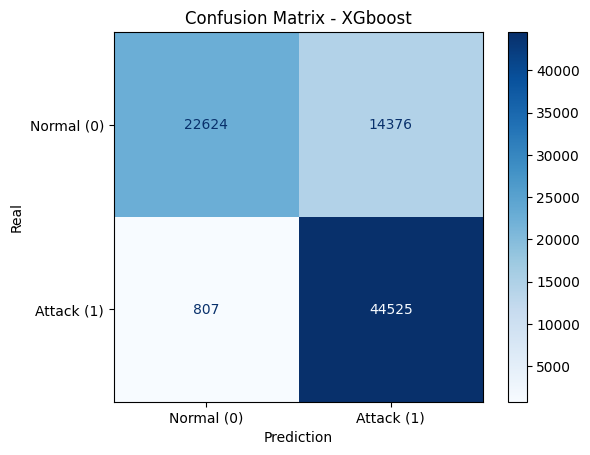

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_preds = {
    "XGboost": y_pred_xgb,
}

for name, y_pred in model_preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Attack (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.show()

In [9]:
import joblib

joblib.dump(rf_improved, '../processed/rf_improved.pkl')
joblib.dump(xgb, '../processed/xgb.pkl')

['../processed/xgb.pkl']